In [2]:

import pandas as pd
import numpy as np
#import prospr as pr
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
import seaborn as sns
import random
import csv
from collections import Counter
import itertools
import math
import ast


In [5]:
class Protein:
  def __init__(self, sequence , folds=[]):
    self.sequence = sequence
    self.hash_fold = folds
    self.loc_list = []
    self.score = (0,0)
    self.collisions = 0
    self.bonds = 0

    self.update_loc_list()
    self.update_score()

  def update_loc_list(self):

    self.loc_list = []
    moves = self.hash_fold

    # Setup storage of the amino positions.
    cur_pos = [0,0]
    self.loc_list.append((0,0))
    # Save the coordinates of the aminos in order.
    for move in moves:
        cur_pos[abs(move) - 1] += move // abs(move)
        self.loc_list.append(tuple(cur_pos))

    pass

  def random_fold(self):
    self.hash_fold = []
    for _ in range(len(self.sequence)-1) :
        direction = np.random.choice([-2, -1, 1, 2])
        self.hash_fold.append(direction)
    self.update_loc_list()
    pass

  def set_hash(self, index, direction, update = True):
    self.hash_fold[index] = direction

    if update:
      self.update_loc_list()
      self.update_score()
    pass

  def mutate(self):
    index = np.random.randint(0,len(self.hash_fold))
    new_number = np.random.choice([-2, -1, 1, 2])
    self.hash_fold[index] = new_number

    self.update_loc_list()
    self.update_score()
    pass

  def remove_back(self):
    for i in range(1, len(self.hash_fold)):
        # Check if the current element is the negative of the previous element
        if self.hash_fold[i] == -self.hash_fold[i - 1]:
            # Modify the current element to a different value from the possible options
            while True:
                new_value = np.random.choice([-2, -1, 1, 2])
                if new_value != -self.hash_fold[i - 1]:
                    self.hash_fold[i] = new_value
                    break
    self.update_loc_list()
    pass

  def get_bonds(self):
    bonds = 0
    for i, loc in enumerate(self.loc_list):
      if self.sequence[i] == 'H':
         x,y = loc
         directions = [(1,0), (-1,0), (0,1), (0,-1)]
         neighbours = [(x + dx, y + dy) for dx, dy in directions]
         for neighbour in neighbours:
            if self.find_neighbours(neighbour, self.sequence[i+2:] ,self.loc_list[i+2:]):
               bonds += 1
    self.bonds = bonds
    return bonds

  def find_neighbours(self, loc, changed_seq, changed_loc):
    aminos = []
    for i, item in enumerate(changed_loc):
      if item == loc:
        if changed_seq[i] == 'H':
          aminos.append(i)
    if len(aminos) > 0:
       return True
    else:
       return False

  def get_pairs(self):
    pairs = []
    for i, loc in enumerate(self.loc_list):
      if self.sequence[i] == 'H':
         x,y = loc
         directions = [(1,0), (-1,0), (0,1), (0,-1)]
         neighbours = [(x + dx, y + dy) for dx, dy in directions]
         for neighbour in neighbours:
            if self.find_neighbours(neighbour, self.sequence[i+2:], self.loc_list[i+2:]):
               pairs.append((loc,neighbour))
    return pairs

  def get_collision(self):
    collision_count = 0
    visited_positions = set()

    for coordinate in self.loc_list:
        if coordinate in visited_positions:
            collision_count += 1
        else:
            visited_positions.add(coordinate)

    self.collisions = collision_count
    return collision_count

  def update_score(self):
    self.get_collision()
    self.get_bonds()
    self.score = (self.bonds, self.collisions)
    pass

  def __str__(self):
    return f"Protein: {len(self.sequence)}\nSequence: {self.sequence}\nFolds: {self.hash_fold}"



In [6]:
def get_ordered_positions(protein):
    """
    Fetch the positions of the currently folded amino chain in order of
    placement.
    """
    # Fetch done moves and the aminos used so far.
    moves = protein.hash_fold
    aminos = protein.sequence[: len(moves) + 1]

    # Setup storage of the amino positions.
    cur_pos = np.array([0 for _ in range(2)], dtype=np.int64)
    positions = np.array([*cur_pos, aminos[0]])

    # Save the coordinates of the aminos in order.
    for amino, move in zip(aminos[1:], moves):
        cur_pos[abs(move) - 1] += move // abs(move)
        positions = np.vstack((positions, np.array([*cur_pos, amino])))

    return positions


In [7]:
def hc_c(protein, max_iterations):
    data = []
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    best_fitness = current_protein.get_collision()
    best_solution = current_protein.hash_fold
    data.append([0,best_fitness])

    for _ in range(max_iterations):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()

        if mutated_protein.collisions <= best_fitness:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))
            best_solution = current_protein.hash_fold
            best_fitness = current_protein.collisions
            data.append([_, best_fitness])

        #if _ % 100 == 0:
        #   print("Interation: " + str(_))

    return current_protein, best_solution, best_fitness, data

In [8]:
def hc_b(protein, max_iterations):
    data = []
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    best_fitness = current_protein.get_bonds()
    best_solution = current_protein.hash_fold
    data.append([0,best_fitness])

    for _ in range(max_iterations):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()

        if mutated_protein.bonds >= best_fitness:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))
            best_solution = current_protein.hash_fold
            best_fitness = current_protein.bonds
            data.append([_, best_fitness])

        #if _ % 100 == 0:
        #   print("Interation: " + str(_))

    return current_protein, best_solution, best_fitness, data

In [9]:
def hc_c_ffa(protein, max_iterations):
    data = []
    fitness_dict = {}
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    best_fitness = current_protein.get_collision()
    current_fitness = current_protein.get_collision()
    best_solution = current_protein.hash_fold
    data.append([0, current_fitness ,best_fitness])
    fitness_dict.setdefault(current_fitness, 1)

    for _ in range(max_iterations):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()
        if mutated_protein.collisions in fitness_dict:
            fitness_dict[mutated_protein.collisions] += 1
        else:
            fitness_dict.setdefault(mutated_protein.collisions, 1)
        fitness_dict[current_fitness] += 1


        if fitness_dict[mutated_protein.collisions] <= fitness_dict[current_fitness]:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))
            current_fitness = current_protein.collisions

            if current_fitness <= best_fitness:
                best_solution = current_protein.hash_fold
                best_fitness = current_protein.collisions 
            
            data.append([_, current_fitness ,best_fitness])

        #if _ % 100 == 0:
        #   print("Interation: " + str(_))

    return current_protein, best_solution, best_fitness, data

In [10]:
def hc_b_ffa(protein, max_iterations):
    data = []
    fitness_dict = {}
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    best_fitness = current_protein.get_bonds()
    current_fitness = current_protein.get_bonds()
    best_solution = current_protein.hash_fold
    data.append([0, current_fitness ,best_fitness])
    fitness_dict.setdefault(current_fitness, 1)

    for _ in range(max_iterations):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()
        if mutated_protein.bonds in fitness_dict:
            fitness_dict[mutated_protein.bonds] += 1
        else:
            fitness_dict.setdefault(mutated_protein.bonds, 1)
        fitness_dict[current_fitness] += 1


        if fitness_dict[mutated_protein.bonds] <= fitness_dict[current_fitness]:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))
            current_fitness = current_protein.bonds

            if current_fitness >= best_fitness:
                best_solution = current_protein.hash_fold
                best_fitness = current_protein.bonds 
            
            data.append([_, current_fitness ,best_fitness])

        #if _ % 100 == 0:
        #   print("Interation: " + str(_))

    return current_protein, best_solution, best_fitness, data

In [11]:
def check_dom(mutated, fitnesslist): 
    dominated = False
    exists = False
    old_scores = []

    for set in fitnesslist:
        if mutated[1] >= set[1] and mutated[0] <= set[0] and not (mutated == set):
            dominated = True
            break
        if mutated[1] <= set[1] and mutated[0] >= set[0]:
            old_scores.append(set)
            if mutated == set:
                exists = True

    return dominated, exists, old_scores

In [154]:
def mhc(protein, max_iterations):
    data = []
    fitnesslist = []
    solutiondict = {}
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    fitnesslist.append(current_protein.score)
    solutiondict[current_protein.score] = current_protein.hash_fold

    data.append([0,fitnesslist.copy()])

    for _ in range(max_iterations):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()

        dominated, exists, old_scores = check_dom(mutated_protein.score, fitnesslist)

        if not dominated:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))
            solutiondict[current_protein.score] = current_protein.hash_fold
            if not exists:
                for set in old_scores:
                    del solutiondict[set]
                    fitnesslist.remove(set)
                fitnesslist.append(current_protein.score)
                
            data.append([_, fitnesslist.copy()])

    return current_protein, solutiondict, fitnesslist, data

In [155]:
def mhc_ffa(protein, max_iterations):
    data = []
    fitnesslist = []
    solutiondict = {}
    fitnessdict = {}
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    fitnesslist.append(current_protein.score)
    solutiondict[current_protein.score] = current_protein.hash_fold
    fitnessdict.setdefault(current_protein.score, 1)


    data.append([0, current_protein.score, fitnesslist.copy()])

    for _ in range(max_iterations):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()
        if mutated_protein.score in fitnessdict:
            fitnessdict[mutated_protein.score] += 1
        else:
            fitnessdict.setdefault(mutated_protein.score, 1)
        fitnessdict[current_protein.score] += 1

        if fitnessdict[mutated_protein.score] <= fitnessdict[current_protein.score]:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))

            dominated, exists, old_scores = check_dom(mutated_protein.score, fitnesslist)

            if not dominated:
                if not exists:
                    for set in old_scores:
                        del solutiondict[set]
                        fitnesslist.remove(set)
                    fitnesslist.append(current_protein.score)
                solutiondict[current_protein.score] = current_protein.hash_fold
                    
            data.append([_, current_protein.score, fitnesslist.copy()])

    return current_protein, solutiondict, fitnesslist, data

In [14]:
def random_sequence(length, HP = 0.5):
    sequence = ""
    for i in range(length):
        if random.random() < HP:
            sequence += "P"
        else:
            sequence += "H"
    return sequence

In [10]:
# numbers = range(20, 201, 20)

# combined = []

# for number in numbers:
#     data = [] 
#     for i in range(5):
#         protein = Protein(random_sequence(number))
#         protein.random_fold()
#         data.append(protein)
#     df = pd.DataFrame(data)
#     combined.append(df)

# # Create a single DataFrame from all generated DataFrames
# Database = pd.concat(combined)

# print(Database)

In [11]:
#Database.to_csv("Database.csv")

In [3]:
# Open the CSV file in read mode
with open('Database.csv', 'r') as csvfile:
    # Create a DictReader object
    reader = csv.DictReader(csvfile)

    # Convert each row to a dictionary
    data = []
    for row in reader:
        data.append(row)

    # Convert the list of dictionaries to a DataFrame
    Database = pd.DataFrame(data)

In [6]:
ratios = []

for _, protein_data in Database.iterrows():
    sequence = protein_data[1].split("\n")[1].split(":")[1].strip()
    
    # Count the occurrences of 'H' and 'P'
    count_H = sequence.count('H')
    count_P = sequence.count('P')
    
    # Calculate the ratio
    if count_P > 0:
        ratio = count_H / (count_P + count_H)
    else:
        ratio = float('inf')  # or some other value indicating undefined ratio
    
    ratios.append(ratio)

ratios

[0.4,
 0.6,
 0.55,
 0.45,
 0.5,
 0.5,
 0.75,
 0.425,
 0.425,
 0.525,
 0.55,
 0.5666666666666667,
 0.5333333333333333,
 0.6,
 0.45,
 0.4875,
 0.4625,
 0.4375,
 0.3625,
 0.4375,
 0.56,
 0.59,
 0.52,
 0.52,
 0.5,
 0.525,
 0.5166666666666667,
 0.4583333333333333,
 0.5083333333333333,
 0.5083333333333333,
 0.5142857142857142,
 0.4928571428571429,
 0.5428571428571428,
 0.5214285714285715,
 0.5214285714285715,
 0.50625,
 0.5375,
 0.475,
 0.4375,
 0.51875,
 0.5277777777777778,
 0.5055555555555555,
 0.4444444444444444,
 0.4888888888888889,
 0.42777777777777776,
 0.43,
 0.475,
 0.505,
 0.525,
 0.54]

In [13]:
results = []
resultsFFA = []

for _, protein_data in Database.iterrows():
    sequence = protein_data[1].split("\n")[1].split(":")[1].strip()
    folds = eval(protein_data[1].split("\n")[2].split(":")[1].strip())
    protein = Protein(sequence, folds=folds)
    current_protein, best_solution, best_fitness, data = hc_c(protein, 100000)
    results.append([current_protein, best_solution, best_fitness, data])
    current_protein, best_solution, best_fitness, data = hc_c_ffa(protein, 100000)
    resultsFFA.append([current_protein, best_solution, best_fitness, data])

    print(str(len(protein.sequence)) + " iter " + str(_))

20 iter 0
20 iter 1
20 iter 2
20 iter 3
20 iter 4
40 iter 5
40 iter 6
40 iter 7
40 iter 8
40 iter 9
60 iter 10
60 iter 11
60 iter 12
60 iter 13
60 iter 14
80 iter 15
80 iter 16
80 iter 17
80 iter 18
80 iter 19
100 iter 20
100 iter 21
100 iter 22
100 iter 23
100 iter 24
120 iter 25
120 iter 26
120 iter 27
120 iter 28
120 iter 29
140 iter 30
140 iter 31
140 iter 32
140 iter 33
140 iter 34
160 iter 35
160 iter 36
160 iter 37
160 iter 38
160 iter 39
180 iter 40
180 iter 41
180 iter 42
180 iter 43
180 iter 44
200 iter 45
200 iter 46
200 iter 47
200 iter 48
200 iter 49


In [14]:
df = pd.DataFrame(results)
df.to_json("Collisions.json")

In [15]:
dfFFA = pd.DataFrame(resultsFFA)
dfFFA.to_json("Collisions_FFA.json")

In [16]:
results = []
resultsFFA = []

for _, protein_data in Database.iterrows():
    sequence = protein_data[1].split("\n")[1].split(":")[1].strip()
    folds = eval(protein_data[1].split("\n")[2].split(":")[1].strip())
    protein = Protein(sequence, folds=folds)
    current_protein, best_solution, best_fitness, data = hc_b(protein, 100000)
    results.append([current_protein, best_solution, best_fitness, data])

    current_protein, best_solution, best_fitness, data = hc_b_ffa(protein, 100000)
    resultsFFA.append([current_protein, best_solution, best_fitness, data])

    print(str(len(protein.sequence)) + " iter " + str(_))

20 iter 0
20 iter 1
20 iter 2
20 iter 3
20 iter 4
40 iter 5
40 iter 6
40 iter 7
40 iter 8
40 iter 9
60 iter 10
60 iter 11
60 iter 12
60 iter 13
60 iter 14
80 iter 15
80 iter 16
80 iter 17
80 iter 18
80 iter 19
100 iter 20
100 iter 21
100 iter 22
100 iter 23
100 iter 24
120 iter 25
120 iter 26
120 iter 27
120 iter 28
120 iter 29
140 iter 30
140 iter 31
140 iter 32
140 iter 33
140 iter 34
160 iter 35
160 iter 36
160 iter 37
160 iter 38
160 iter 39
180 iter 40
180 iter 41
180 iter 42
180 iter 43
180 iter 44
200 iter 45
200 iter 46
200 iter 47
200 iter 48
200 iter 49


In [157]:
results = []
resultsFFA = []

for _, protein_data in Database.iterrows():
    sequence = protein_data[1].split("\n")[1].split(":")[1].strip()
    folds = eval(protein_data[1].split("\n")[2].split(":")[1].strip())
    protein = Protein(sequence, folds=folds)
    current_protein, best_solution, best_fitness, data = mhc(protein, 100000)
    results.append([current_protein, best_solution, best_fitness, data])

    current_protein, best_solution, best_fitness, data = mhc_ffa(protein, 100000)
    resultsFFA.append([current_protein, best_solution, best_fitness, data])

    print(str(len(protein.sequence)) + " iter " + str(_))

20 iter 0
20 iter 1
20 iter 2
20 iter 3
20 iter 4
40 iter 5
40 iter 6
40 iter 7
40 iter 8
40 iter 9
60 iter 10
60 iter 11
60 iter 12
60 iter 13
60 iter 14
80 iter 15
80 iter 16
80 iter 17
80 iter 18
80 iter 19
100 iter 20
100 iter 21
100 iter 22
100 iter 23
100 iter 24
120 iter 25
120 iter 26
120 iter 27
120 iter 28
120 iter 29
140 iter 30
140 iter 31
140 iter 32
140 iter 33
140 iter 34
160 iter 35
160 iter 36
160 iter 37
160 iter 38
160 iter 39
180 iter 40
180 iter 41
180 iter 42
180 iter 43
180 iter 44
200 iter 45
200 iter 46
200 iter 47
200 iter 48
200 iter 49


In [187]:
df = pd.DataFrame(results)
df.to_json("MOHC2.json")

In [188]:
dfFFA = pd.DataFrame(resultsFFA)
dfFFA.to_json("MOHC_FFA2.json")

In [189]:
MoHC = pd.read_json("MOHC2.json")
MoHCFFA = pd.read_json("MOHC_FFA2.json")

In [16]:
Bondsdf = pd.read_json("Bonds.json")
BondsdFFA = pd.read_json("Bonds_FFA.json")


In [17]:
Coldf = pd.read_json("Collisions.json")
ColdFFA = pd.read_json("Collisions_FFA.json")

In [190]:
# for i in range(0, len(ColdFFA)):
#     ColdFFA.loc[i, 'length'] = 20 + (20 * (( i - (i % 5)) / 5))
# for i in range(0, len(Bondsdf)):
#     Bondsdf.loc[i, 'length'] = 20 + (20 * (( i - (i % 5)) / 5))
# for i in range(0, len(BondsdFFA)):
#     BondsdFFA.loc[i, 'length'] = 20 + (20 * (( i - (i % 5)) / 5))
# for i in range(0, len(Coldf)):
#     Coldf.loc[i, 'length'] = 20 + (20 * (( i - (i % 5)) / 5))
# for i in range(0, len(MoHC)):
#     MoHC.loc[i, 'length'] = 20 + (20 * (( i - (i % 5)) / 5))
# for i in range(0, len(MoHCFFA)):
#     MoHCFFA.loc[i, 'length'] = 20 + (20 * (( i - (i % 5)) / 5))

In [191]:
# ColdFFA = ColdFFA.rename(columns={0: "Final Protein", 1: "Fold", 2: "Fitness", 3: "Data"})
# Bondsdf = Bondsdf.rename(columns={0: "Final Protein", 1: "Fold", 2: "Fitness", 3: "Data"})
# BondsdFFA = BondsdFFA.rename(columns={0: "Final Protein", 1: "Fold", 2: "Fitness", 3: "Data"})
# Coldf = Coldf.rename(columns={0: "Final Protein", 1: "Fold", 2: "Fitness", 3: "Data"})
# MoHC = MoHC.rename(columns={0: "Final Protein", 1: "Fold", 2: "Fitness", 3: "Data"})
# MoHCFFA = MoHCFFA.rename(columns={0: "Final Protein", 1: "Fold", 2: "Fitness", 3: "Data"})

In [23]:
for index, row in BondsdFFA.iterrows():
    # Append [100000, fitness] to the 'Data' column of the current row
    fitness = row['Fitness']
    BondsdFFA.at[index, 'Data'].append([100000, fitness])

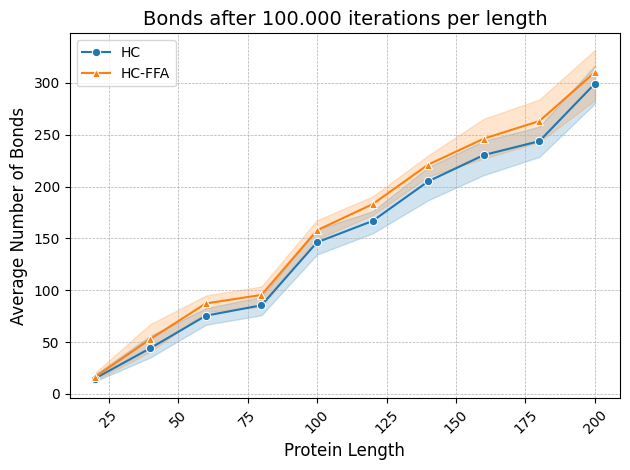

In [20]:

# Create line plots for current and best solutions
#sns.lineplot(x='Iteration', y='Current Solution', data=df)
sns.lineplot(x='length', y='Fitness', data=Bondsdf, label="HC", marker="o", linestyle="-", color="#1f77b4")
sns.lineplot(x='length', y='Fitness', data=BondsdFFA, label="HC-FFA", marker="^", linestyle="-", color="#ff7f0e")

# Set labels and title
plt.xlabel('Protein Length', fontsize=12)
plt.ylabel('Average Number of Bonds', fontsize=12)

plt.legend(loc="upper left", prop={"size": 10})
#plt.xscale('log')
plt.title('Bonds after 100.000 iterations per length', fontsize=14)

plt.xticks(rotation=45)

# Use a more professional font
plt.rcParams["font.family"] = "Times New Roman"

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

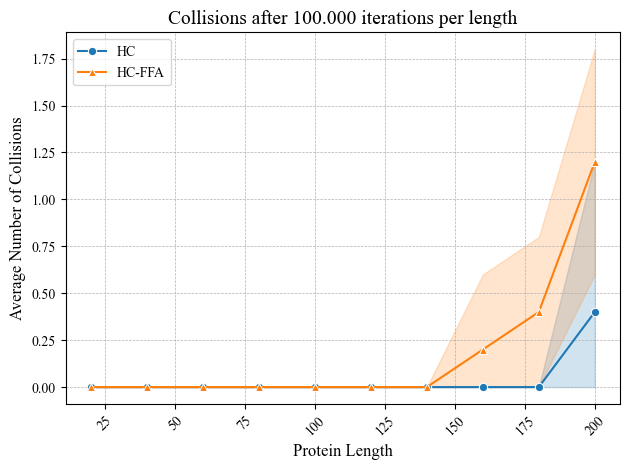

In [21]:
sns.lineplot(x='length', y='Fitness', data=Coldf, label="HC", marker="o", linestyle="-", color="#1f77b4")
sns.lineplot(x='length', y='Fitness', data=ColdFFA, label="HC-FFA", marker="^", linestyle="-", color="#ff7f0e")

# Set labels and title
plt.xlabel('Protein Length', fontsize=12)
plt.ylabel('Average Number of Collisions', fontsize=12)

plt.legend(loc="upper left", prop={"size": 10})
#plt.xscale('log')
plt.title('Collisions after 100.000 iterations per length', fontsize=14)

plt.xticks(rotation=45)

# Use a more professional font
plt.rcParams["font.family"] = "Times New Roman"

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [71]:
testdf = pd.DataFrame(pd.DataFrame(Bondsdf["Data"][0], columns=['Iteration', 'Fitness']))[1:]

# Set 'Iteration' as the index
testdf.set_index('Iteration', inplace=True)

# Reindex the DataFrame to include all iterations
testdf = testdf.reindex(np.arange(0, 100001))

# Forward fill the missing fitness values
testdf['Fitness'].ffill(inplace=True)

# Reset the index
testdf.reset_index(inplace=True)

In [57]:
dataFrames = []

for i in range(len(Bondsdf)):
    # Access the data list for each entry
    data = Bondsdf["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Fitness'])


    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100001))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)

    df['length'] = 20 + (20 * (( i - (i % 5)) / 5))

    

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Bonds_Data = pd.concat(dataFrames, ignore_index=True)

In [59]:
dataFrames = []

for i in range(len(Coldf)):
    # Access the data list for each entry
    data = Coldf["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100000))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)

    df['length'] = 20 + (20 * (( i - (i % 5)) / 5))

    

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Col_Data = pd.concat(dataFrames, ignore_index=True)

In [60]:
dataFrames = []

for i in range(len(BondsdFFA)):
    # Access the data list for each entry
    data = BondsdFFA["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Current', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100001))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)
    df['Current'].ffill(inplace=True)

    df['length'] = 20 + (20 * (( i - (i % 5)) / 5))

    

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
BondsFFA_Data = pd.concat(dataFrames, ignore_index=True)

In [61]:
dataFrames = []

for i in range(len(ColdFFA)):
    # Access the data list for each entry
    data = ColdFFA["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Current', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100001))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)
    df['Current'].ffill(inplace=True)

    df['length'] = 20 + (20 * (( i - (i % 5)) / 5))

    

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
ColFFA_Data = pd.concat(dataFrames, ignore_index=True)

In [62]:
AvgBondsFFA_Data = BondsFFA_Data.groupby(['Iteration', 'length'], as_index=False).agg({'Fitness':'mean', 'Current':'mean'})

In [63]:
AvgColFFA_Data = ColFFA_Data.groupby(['Iteration', 'length'], as_index=False).agg({'Fitness':'mean', 'Current':'mean'})

In [64]:
AvgBonds_Data = Bonds_Data.groupby(['Iteration', 'length'], as_index=False)['Fitness'].mean()

In [65]:
AvgCol_Data = Col_Data.groupby(['Iteration', 'length'], as_index=False)['Fitness'].mean()

In [74]:
mask = (AvgBonds_Data['length'] == 80) & (AvgBonds_Data['Iteration'] < 10)

AvgBonds_Data[mask]

,Iteration,length,Fitness
3,0,80,32.3
13,1,80,32.8
23,2,80,33.0
33,3,80,33.0
43,4,80,33.4
53,5,80,33.4
63,6,80,34.0
73,7,80,34.0
83,8,80,34.8
93,9,80,36.6


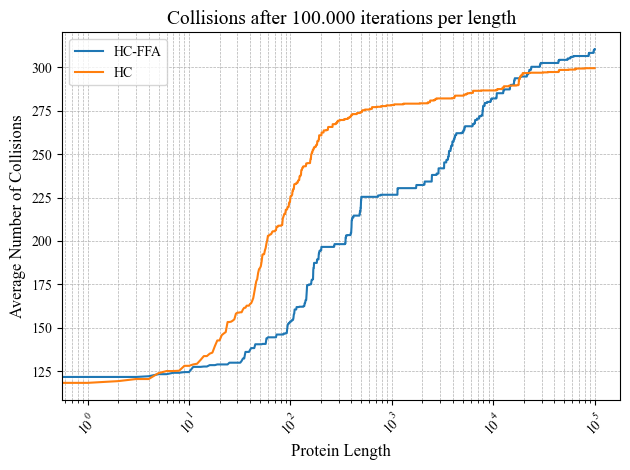

In [66]:
sns.lineplot(x='Iteration', y='Fitness', data=AvgBondsFFA_Data[AvgBondsFFA_Data['length'] == 200], label='HC-FFA', linestyle="-")
sns.lineplot(x='Iteration', y='Fitness', data=AvgBonds_Data[AvgBonds_Data['length'] == 200], label='HC', linestyle="-")

plt.xlabel('Protein Length', fontsize=12)
plt.ylabel('Average Number of Collisions', fontsize=12)

plt.legend(loc="upper left", prop={"size": 10})
plt.xscale('log')
plt.title('Collisions after 100.000 iterations per length', fontsize=14)

plt.xticks(rotation=45)

# Use a more professional font
plt.rcParams["font.family"] = "Times New Roman"

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

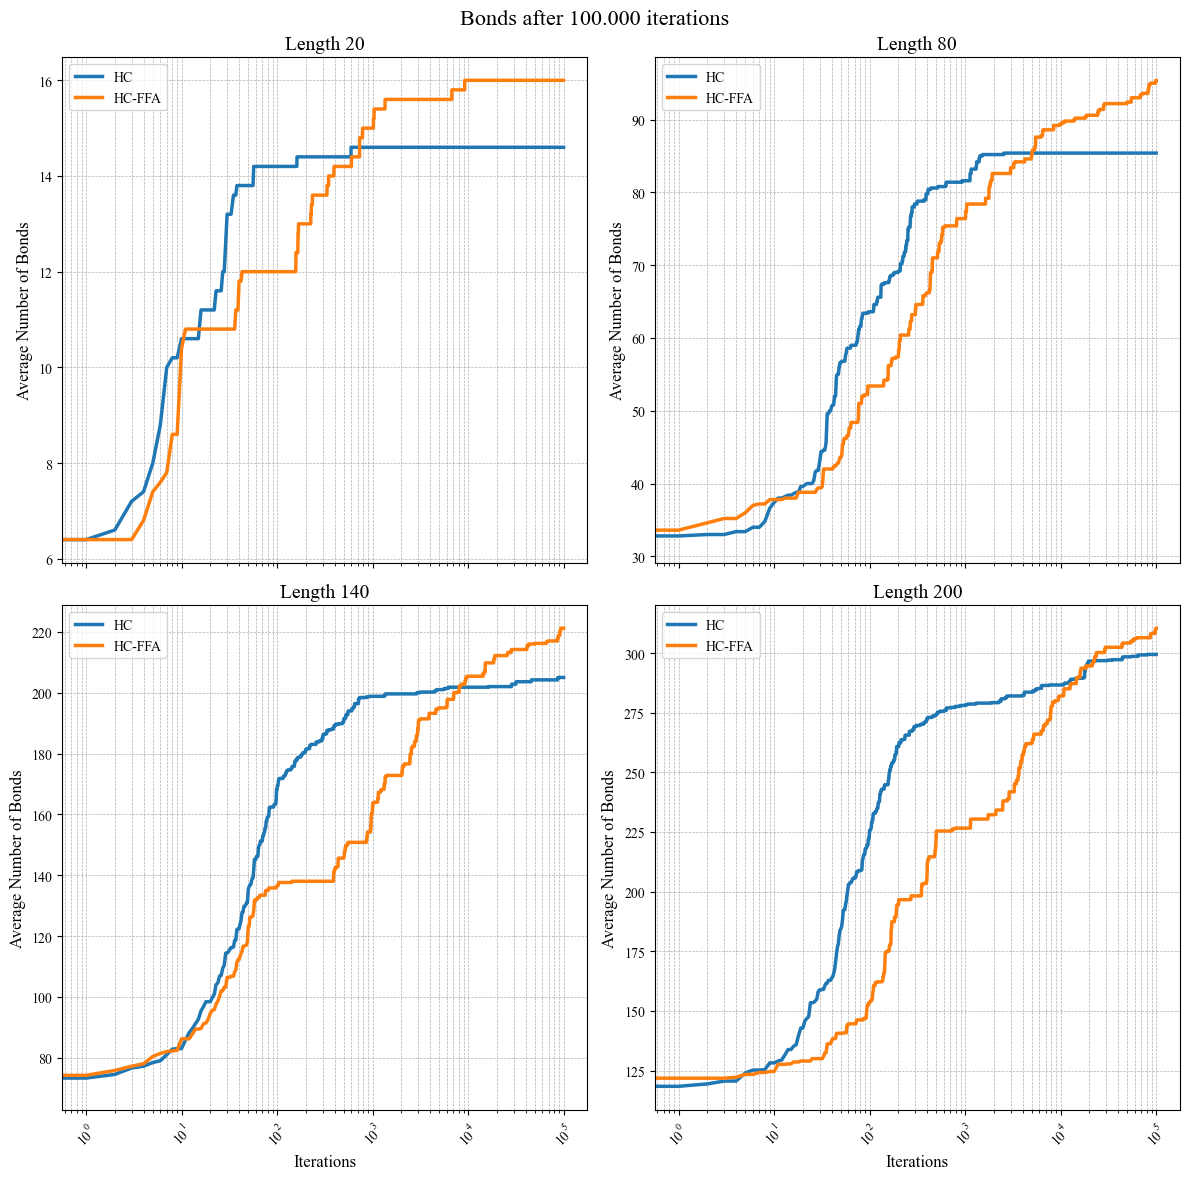

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns


lengths = [20, 80, 140, 200]

# Increase figure size
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Add a figure title
fig.suptitle('Bonds after 100.000 iterations', fontsize=16)

for i, length in enumerate(lengths):
    row = i // 2
    col = i % 2
    sns.lineplot(x='Iteration', y='Fitness', data=AvgBonds_Data[AvgBonds_Data['length'] == length], label='HC', linestyle="-", ax=axs[row, col], linewidth=2.5)
    sns.lineplot(x='Iteration', y='Fitness', data=AvgBondsFFA_Data[AvgBondsFFA_Data['length'] == length], label='HC-FFA', linestyle="-", ax=axs[row, col], linewidth=2.5)

    axs[row, col].set_ylabel('Average Number of Bonds', fontsize=12)
    axs[row, col].legend(loc="upper left", prop={"size": 10})
    axs[row, col].set_xscale('log')
    axs[row, col].set_title(f'Length {length}', fontsize=14)
    axs[row, col].tick_params(axis='x', rotation=45)
    axs[row, col].grid(True, which="both", linestyle="--", linewidth=0.5)

    # Remove x-axis label and values for the top graphs
    if row == 0:
        axs[row, col].set_xlabel('')
        axs[row, col].set_xticklabels([])
    else:
        axs[row, col].set_xlabel('Iterations', fontsize=12)

plt.tight_layout()
plt.show()


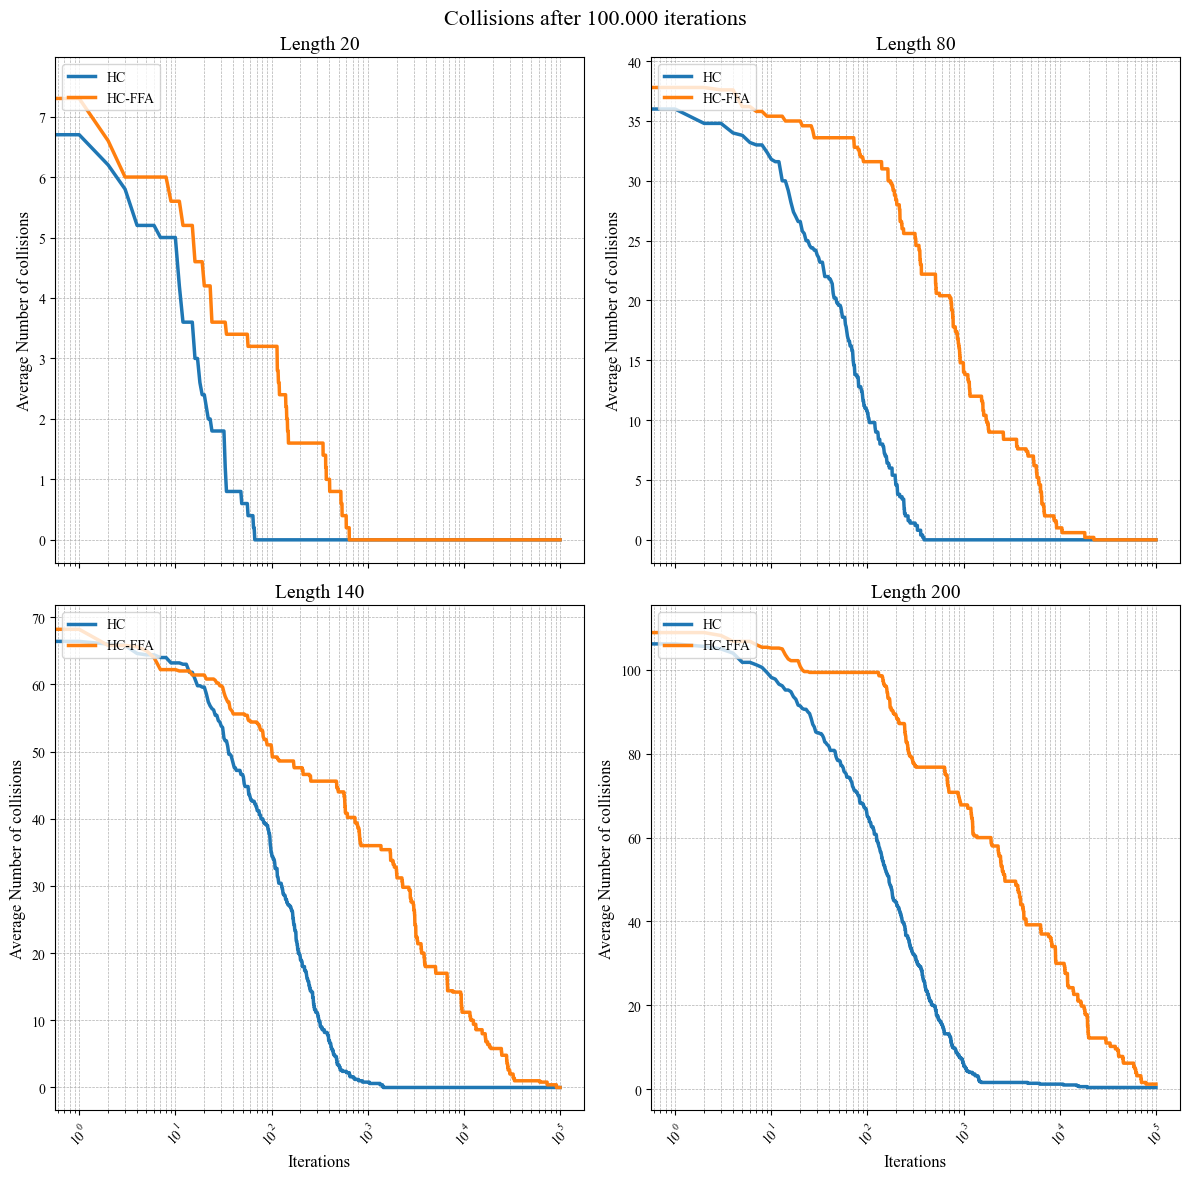

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns


lengths = [20, 80, 140, 200]

# Increase figure size
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Add a figure title
fig.suptitle('Collisions after 100.000 iterations', fontsize=16)

for i, length in enumerate(lengths):
    row = i // 2
    col = i % 2
    sns.lineplot(x='Iteration', y='Fitness', data=AvgCol_Data[AvgCol_Data['length'] == length], label='HC', linestyle="-", ax=axs[row, col], linewidth=2.5)
    sns.lineplot(x='Iteration', y='Fitness', data=AvgColFFA_Data[AvgColFFA_Data['length'] == length], label='HC-FFA', linestyle="-", ax=axs[row, col], linewidth=2.5)

    axs[row, col].set_ylabel('Average Number of collisions', fontsize=12)
    axs[row, col].legend(loc="upper left", prop={"size": 10})
    axs[row, col].set_xscale('log')
    axs[row, col].set_title(f'Length {length}', fontsize=14)
    axs[row, col].tick_params(axis='x', rotation=45)
    axs[row, col].grid(True, which="both", linestyle="--", linewidth=0.5)

    # Remove x-axis label and values for the top graphs
    if row == 0:
        axs[row, col].set_xlabel('')
        axs[row, col].set_xticklabels([])
    else:
        axs[row, col].set_xlabel('Iterations', fontsize=12)

plt.tight_layout()
plt.show()


In [192]:
MoHCFFA["MinSolution"] = MoHCFFA["Fitness"].apply(lambda x: min(x, key=lambda y: y[1]))
MoHCFFA["MaxSolution"] = MoHCFFA["Fitness"].apply(lambda x: max(x, key=lambda y: y[0]))
MoHC["MinSolution"] = MoHC["Fitness"].apply(lambda x: min(x, key=lambda y: y[1]))
MoHC["MaxSolution"] = MoHC["Fitness"].apply(lambda x: max(x, key=lambda y: y[0]))

In [193]:
MinCol = [i[1] for i in MoHC['MinSolution']]
MinBonds = [i[0]  for i in MoHC['MinSolution']]

MinCol2 = [i[1] for i in MoHCFFA['MinSolution']]
MinBonds2 = [i[0] for i in MoHCFFA['MinSolution']]

In [194]:
mindf = pd.DataFrame({'Col': MinCol, 'Bonds': MinBonds, 'Length': MoHC['length']})
min2df = pd.DataFrame({'Col': MinCol2, 'Bonds': MinBonds2, 'Length': MoHCFFA['length']})


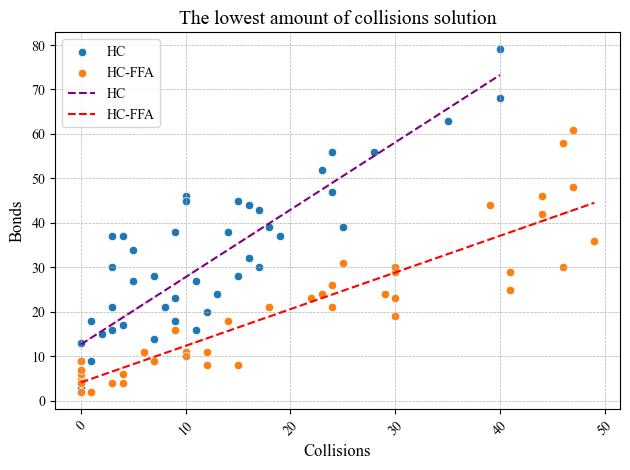

In [234]:
sns.scatterplot(x='Col', y='Bonds', label='HC' ,data=mindf, color=sns.color_palette()[0])
sns.scatterplot(x='Col', y='Bonds', label='HC-FFA' ,data=min2df, color=sns.color_palette()[1])

# Calculate trendline for test
z = np.polyfit(mindf['Col'], mindf['Bonds'], 1)
p = np.poly1d(z)
sns.lineplot(x=mindf['Col'], y=p(mindf['Col']), linestyle="--", label='HC' ,color='purple')

# ci = 1.96 * np.std(test['Bondstest'])/np.sqrt(len(test['Coltest']))
# plt.plot(test['Coltest'], p(test['Coltest']), linestyle="--", color="#1f77b4")
# plt.fill_between(test['Coltest'], (p(test['Coltest'])-ci), (p(test['Coltest'])+ci), color='b', alpha=.1)



# Calculate trendline for test2
z2 = np.polyfit(min2df['Col'], min2df['Bonds'], 1)
p2 = np.poly1d(z2)
sns.lineplot(x=min2df['Col'], y=p2(min2df['Col']), linestyle="--", label='HC-FFA' ,color='red')

# ci2 = 1.96 * np.std(test2['Bondstest2'])/np.sqrt(len(test2['Coltest2']))
# plt.plot(test2['Coltest2'], p2(test2['Coltest2']), linestyle="--", color="#000000")
# plt.fill_between(test2['Coltest2'], (p2(test2['Coltest2'])-ci2), (p2(test2['Coltest2'])+ci2), color='b', alpha=.1)

# Set labels and title
plt.xlabel('Collisions', fontsize=12)
plt.ylabel('Bonds', fontsize=12)
#plt.xlim(0,50)
#plt.ylim(0,25)

plt.legend(loc="upper left", prop={"size": 10})
#plt.xscale('log')
plt.title('The lowest amount of collisions solution', fontsize=14)

plt.xticks(rotation=45)

# Use a more professional font
plt.rcParams["font.family"] = "Times New Roman"

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot 
plt.tight_layout()
plt.show()

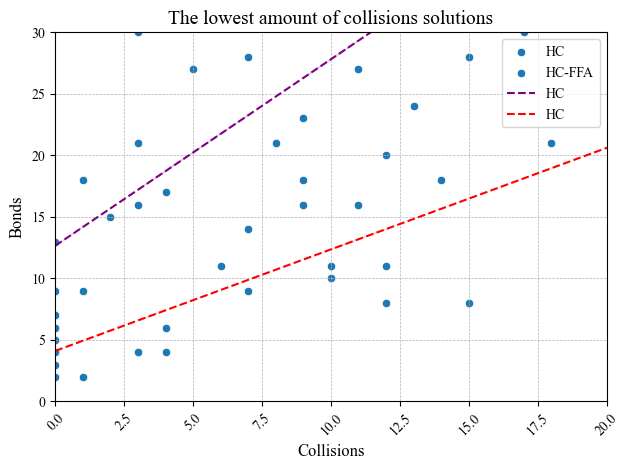

In [233]:
sns.scatterplot(x='Col', y='Bonds', label='HC' ,data=mindf, color=sns.color_palette()[0])
sns.scatterplot(x='Col', y='Bonds', label='HC-FFA' ,data=min2df, color=sns.color_palette()[0])

# Calculate trendline for test
z = np.polyfit(mindf['Col'], mindf['Bonds'], 1)
p = np.poly1d(z)
sns.lineplot(x=mindf['Col'], y=p(mindf['Col']), linestyle="--", label='HC' ,color='purple')

# ci = 1.96 * np.std(test['Bondstest'])/np.sqrt(len(test['Coltest']))
# plt.plot(test['Coltest'], p(test['Coltest']), linestyle="--", color="#1f77b4")
# plt.fill_between(test['Coltest'], (p(test['Coltest'])-ci), (p(test['Coltest'])+ci), color='b', alpha=.1)



# Calculate trendline for test2
z2 = np.polyfit(min2df['Col'], min2df['Bonds'], 1)
p2 = np.poly1d(z2)
sns.lineplot(x=min2df['Col'], y=p2(min2df['Col']), linestyle="--", label='HC' ,color='red')

# ci2 = 1.96 * np.std(test2['Bondstest2'])/np.sqrt(len(test2['Coltest2']))
# plt.plot(test2['Coltest2'], p2(test2['Coltest2']), linestyle="--", color="#000000")
# plt.fill_between(test2['Coltest2'], (p2(test2['Coltest2'])-ci2), (p2(test2['Coltest2'])+ci2), color='b', alpha=.1)

# Set labels and title
plt.xlabel('Collisions', fontsize=12)
plt.ylabel('Bonds', fontsize=12)
plt.xlim(0,20)
plt.ylim(0,30)

plt.legend(loc="upper right", prop={"size": 10})
#plt.xscale('log')
plt.title('The lowest amount of collisions solutions', fontsize=14)

plt.xticks(rotation=45)

# Use a more professional font
plt.rcParams["font.family"] = "Times New Roman"

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot 
plt.tight_layout()
plt.show()

In [197]:
MaxCol = [i[1] for i in MoHC['MaxSolution']]
MaxBonds = [i[0]  for i in MoHC['MaxSolution']]

MaxCol2 = [i[1] for i in MoHCFFA['MaxSolution']]
MaxBonds2 = [i[0] for i in MoHCFFA['MaxSolution']]

In [198]:
maxdf = pd.DataFrame({'Col': MaxCol, 'Bonds': MaxBonds, 'Length': MoHC['length']})
max2df = pd.DataFrame({'Col': MaxCol2, 'Bonds': MaxBonds2, 'Length': MoHCFFA['length']})

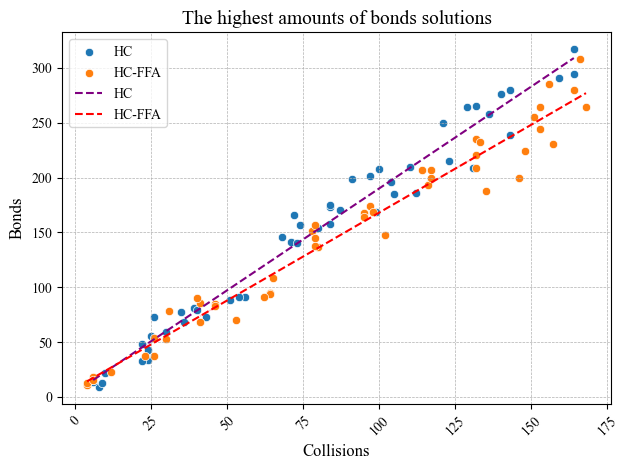

In [232]:
sns.scatterplot(x='Col', y='Bonds', label='HC' ,data=maxdf, color=sns.color_palette()[0])
sns.scatterplot(x='Col', y='Bonds', label='HC-FFA' ,data=max2df, color=sns.color_palette()[1])

# Calculate trendline for test
z = np.polyfit(maxdf['Col'], maxdf['Bonds'], 1)
p = np.poly1d(z)
sns.lineplot(x=maxdf['Col'], y=p(maxdf['Col']), linestyle="--", label='HC' ,color='purple')

# ci = 1.96 * np.std(test['Bondstest'])/np.sqrt(len(test['Coltest']))
# plt.plot(test['Coltest'], p(test['Coltest']), linestyle="--", color="#1f77b4")
# plt.fill_between(test['Coltest'], (p(test['Coltest'])-ci), (p(test['Coltest'])+ci), color='b', alpha=.1)



# Calculate trendline for test2
z2 = np.polyfit(max2df['Col'], max2df['Bonds'], 1)
p2 = np.poly1d(z2)
sns.lineplot(x=max2df['Col'], y=p2(max2df['Col']), linestyle="--", label='HC-FFA' ,color='red')

# ci2 = 1.96 * np.std(test2['Bondstest2'])/np.sqrt(len(test2['Coltest2']))
# plt.plot(test2['Coltest2'], p2(test2['Coltest2']), linestyle="--", color="#000000")
# plt.fill_between(test2['Coltest2'], (p2(test2['Coltest2'])-ci2), (p2(test2['Coltest2'])+ci2), color='b', alpha=.1)

# Set labels and title
plt.xlabel('Collisions', fontsize=12)
plt.ylabel('Bonds', fontsize=12)
#plt.xlim(0,50)
#plt.ylim(0,25)

plt.legend(loc="upper left", prop={"size": 10})
#plt.xscale('log')
plt.title('The highest amounts of bonds solutions', fontsize=14)

plt.xticks(rotation=45)

# Use a more professional font
plt.rcParams["font.family"] = "Times New Roman"

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot 
plt.tight_layout()
plt.show()

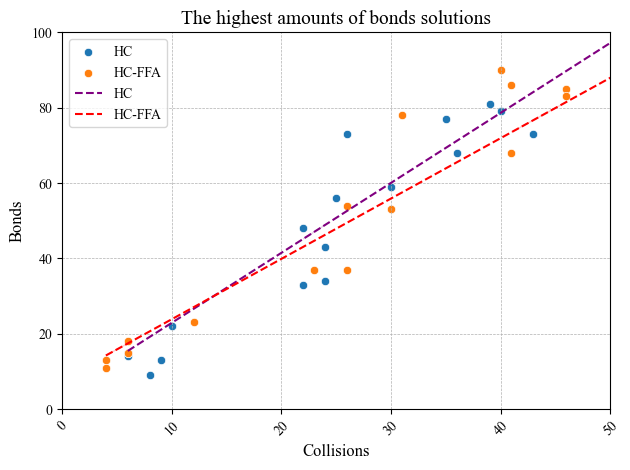

In [231]:
sns.scatterplot(x='Col', y='Bonds', label='HC' ,data=maxdf, color=sns.color_palette()[0])
sns.scatterplot(x='Col', y='Bonds', label='HC-FFA' ,data=max2df, color=sns.color_palette()[1])

# Calculate trendline for test
z = np.polyfit(maxdf['Col'], maxdf['Bonds'], 1)
p = np.poly1d(z)
sns.lineplot(x=maxdf['Col'], y=p(maxdf['Col']), linestyle="--", label='HC' ,color='purple')

# ci = 1.96 * np.std(test['Bondstest'])/np.sqrt(len(test['Coltest']))
# plt.plot(test['Coltest'], p(test['Coltest']), linestyle="--", color="#1f77b4")
# plt.fill_between(test['Coltest'], (p(test['Coltest'])-ci), (p(test['Coltest'])+ci), color='b', alpha=.1)



# Calculate trendline for test2
z2 = np.polyfit(max2df['Col'], max2df['Bonds'], 1)
p2 = np.poly1d(z2)
sns.lineplot(x=max2df['Col'], y=p2(max2df['Col']), linestyle="--", label='HC-FFA' ,color='red')

# ci2 = 1.96 * np.std(test2['Bondstest2'])/np.sqrt(len(test2['Coltest2']))
# plt.plot(test2['Coltest2'], p2(test2['Coltest2']), linestyle="--", color="#000000")
# plt.fill_between(test2['Coltest2'], (p2(test2['Coltest2'])-ci2), (p2(test2['Coltest2'])+ci2), color='b', alpha=.1)

# Set labels and title
plt.xlabel('Collisions', fontsize=12)
plt.ylabel('Bonds', fontsize=12)
plt.xlim(0,50)
plt.ylim(0,100)

plt.legend(loc="upper left", prop={"size": 10})
#plt.xscale('log')
plt.title('The highest amounts of bonds solutions', fontsize=14)

plt.xticks(rotation=45)

# Use a more professional font
plt.rcParams["font.family"] = "Times New Roman"

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot 
plt.tight_layout()
plt.show()

In [201]:
ColAll = [i[1] for j in range(0,50) for i in MoHC['Fitness'][j]]
BondsAll = [i[0]  for j in range(0,50) for i in MoHC['Fitness'][j]]

ColAll2 = [i[1] for j in range(0,50) for i in MoHCFFA['Fitness'][j]]
BondsAll2 = [i[0] for j in range(0,50) for i in MoHCFFA['Fitness'][j]]

In [202]:
HCAll = pd.DataFrame({'Coltest': ColAll, 'Bondstest': BondsAll})
HCFFAAll = pd.DataFrame({'Coltest2': ColAll2, 'Bondstest2': BondsAll2})

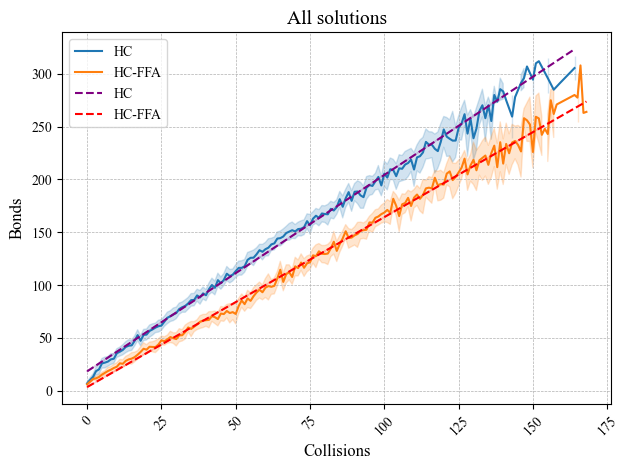

In [235]:
# Create line plots for current and best solutions
#sns.lineplot(x='Iteration', y='Current Solution', data=df)



sns.lineplot(x='Coltest', y='Bondstest', label='HC' ,data=HCAll, linestyle="-", color=sns.color_palette()[0])
sns.lineplot(x='Coltest2', y='Bondstest2', label='HC-FFA' ,data=HCFFAAll, linestyle="-", color=sns.color_palette()[1])

# Calculate trendline for test
z = np.polyfit(HCAll['Coltest'], HCAll['Bondstest'], 1)
p = np.poly1d(z)
sns.lineplot(x=HCAll['Coltest'], y=p(HCAll['Coltest']), linestyle="--", label='HC' ,color='purple')

# ci = 1.96 * np.std(test['Bondstest'])/np.sqrt(len(test['Coltest']))
# plt.plot(test['Coltest'], p(test['Coltest']), linestyle="--", color="#1f77b4")
# plt.fill_between(test['Coltest'], (p(test['Coltest'])-ci), (p(test['Coltest'])+ci), color='b', alpha=.1)



# Calculate trendline for test2
z2 = np.polyfit(HCFFAAll['Coltest2'], HCFFAAll['Bondstest2'], 1)
p2 = np.poly1d(z2)
sns.lineplot(x=HCFFAAll['Coltest2'], y=p2(HCFFAAll['Coltest2']), linestyle="--", label='HC-FFA' ,color='red')

# ci2 = 1.96 * np.std(test2['Bondstest2'])/np.sqrt(len(test2['Coltest2']))
# plt.plot(test2['Coltest2'], p2(test2['Coltest2']), linestyle="--", color="#000000")
# plt.fill_between(test2['Coltest2'], (p2(test2['Coltest2'])-ci2), (p2(test2['Coltest2'])+ci2), color='b', alpha=.1)

# Set labels and title
plt.xlabel('Collisions', fontsize=12)
plt.ylabel('Bonds', fontsize=12)
#plt.xlim(0,50)
#plt.ylim(0,25)

plt.legend(loc="upper left", prop={"size": 10})
#plt.xscale('log')
plt.title('All solutions', fontsize=14)

plt.xticks(rotation=45)

# Use a more professional font
plt.rcParams["font.family"] = "Times New Roman"

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot 
plt.tight_layout()
plt.show()

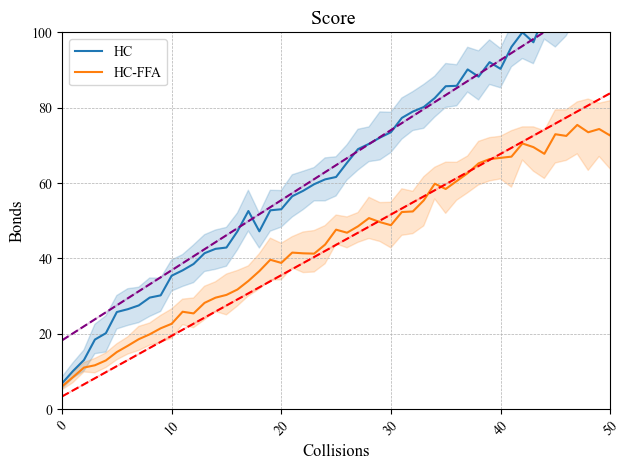

In [229]:
# Create line plots for current and best solutions
#sns.lineplot(x='Iteration', y='Current Solution', data=df)



sns.lineplot(x='Coltest', y='Bondstest', label='HC' ,data=HCAll, linestyle="-", color=sns.color_palette()[0])
sns.lineplot(x='Coltest2', y='Bondstest2', label='HC-FFA' ,data=HCFFAAll, linestyle="-", color=sns.color_palette()[1])

# Calculate trendline for test
z = np.polyfit(HCAll['Coltest'], HCAll['Bondstest'], 1)
p = np.poly1d(z)
sns.lineplot(x=HCAll['Coltest'], y=p(HCAll['Coltest']), linestyle="--", color='purple')

# ci = 1.96 * np.std(test['Bondstest'])/np.sqrt(len(test['Coltest']))
# plt.plot(test['Coltest'], p(test['Coltest']), linestyle="--", color="#1f77b4")
# plt.fill_between(test['Coltest'], (p(test['Coltest'])-ci), (p(test['Coltest'])+ci), color='b', alpha=.1)



# Calculate trendline for test2
z2 = np.polyfit(HCFFAAll['Coltest2'], HCFFAAll['Bondstest2'], 1)
p2 = np.poly1d(z2)
sns.lineplot(x=HCFFAAll['Coltest2'], y=p2(HCFFAAll['Coltest2']), linestyle="--", color='red')

# ci2 = 1.96 * np.std(test2['Bondstest2'])/np.sqrt(len(test2['Coltest2']))
# plt.plot(test2['Coltest2'], p2(test2['Coltest2']), linestyle="--", color="#000000")
# plt.fill_between(test2['Coltest2'], (p2(test2['Coltest2'])-ci2), (p2(test2['Coltest2'])+ci2), color='b', alpha=.1)

# Set labels and title
plt.xlabel('Collisions', fontsize=12)
plt.ylabel('Bonds', fontsize=12)
plt.xlim(0,50)
plt.ylim(0,100)

plt.legend(loc="upper left", prop={"size": 10})
#plt.xscale('log')
plt.title('Score ', fontsize=14)

plt.xticks(rotation=45)

# Use a more professional font
plt.rcParams["font.family"] = "Times New Roman"

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot 
plt.tight_layout()
plt.show()

In [205]:
dataFrames = []

for i in range(len(MoHC)):
    # Access the data list for each entry
    data = MoHC["Data"][i]
    
    df = pd.DataFrame(data, columns=['Iteration', 'Fitness'])

    # Find the pair with the minimal second number using a list comprehension
    df["MinSolution"] = df["Fitness"].apply(lambda x: min(x, key=lambda y: y[1]))
    df['MinCol'] = [i[1] for i in df['MinSolution']]
    df['MinBonds'] = [i[0]  for i in df['MinSolution']]


    df = df.drop(['MinSolution', 'Fitness'], axis=1)

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100001))

    # Forward fill the missing fitness values
    df['MinBonds'].ffill(inplace=True)
    df['MinCol'].ffill(inplace=True)


    df['length'] = 20 + (20 * (( i - (i % 5)) / 5))

    

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
MoHCMin_Data = pd.concat(dataFrames, ignore_index=True)

In [206]:
dataFrames = []

for i in range(len(MoHCFFA)):
    # Access the data list for each entry
    data = MoHCFFA["Data"][i]
    
    df = pd.DataFrame(data, columns=['Iteration', 'Current' ,'Fitness'])

    # Find the pair with the minimal second number using a list comprehension
    df["MinSolution"] = df["Fitness"].apply(lambda x: min(x, key=lambda y: y[1]))
    df['MinCol'] = [i[1] for i in df['MinSolution']]
    df['MinBonds'] = [i[0]  for i in df['MinSolution']]


    df = df.drop(['MinSolution', 'Fitness', 'Current'], axis=1)

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100001))

    # Forward fill the missing fitness values
    df['MinBonds'].ffill(inplace=True)
    df['MinCol'].ffill(inplace=True)


    df['length'] = 20 + (20 * (( i - (i % 5)) / 5))

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
MoHCMinFFA_Data = pd.concat(dataFrames, ignore_index=True)

In [207]:
AvgMoHCMinFFA_Data = MoHCMinFFA_Data.groupby(['Iteration', 'length'], as_index=False).agg({'MinBonds':'mean', 'MinCol':'mean'})
AvgMoHCMin_Data = MoHCMin_Data.groupby(['Iteration', 'length'], as_index=False).agg({'MinBonds':'mean', 'MinCol':'mean'})

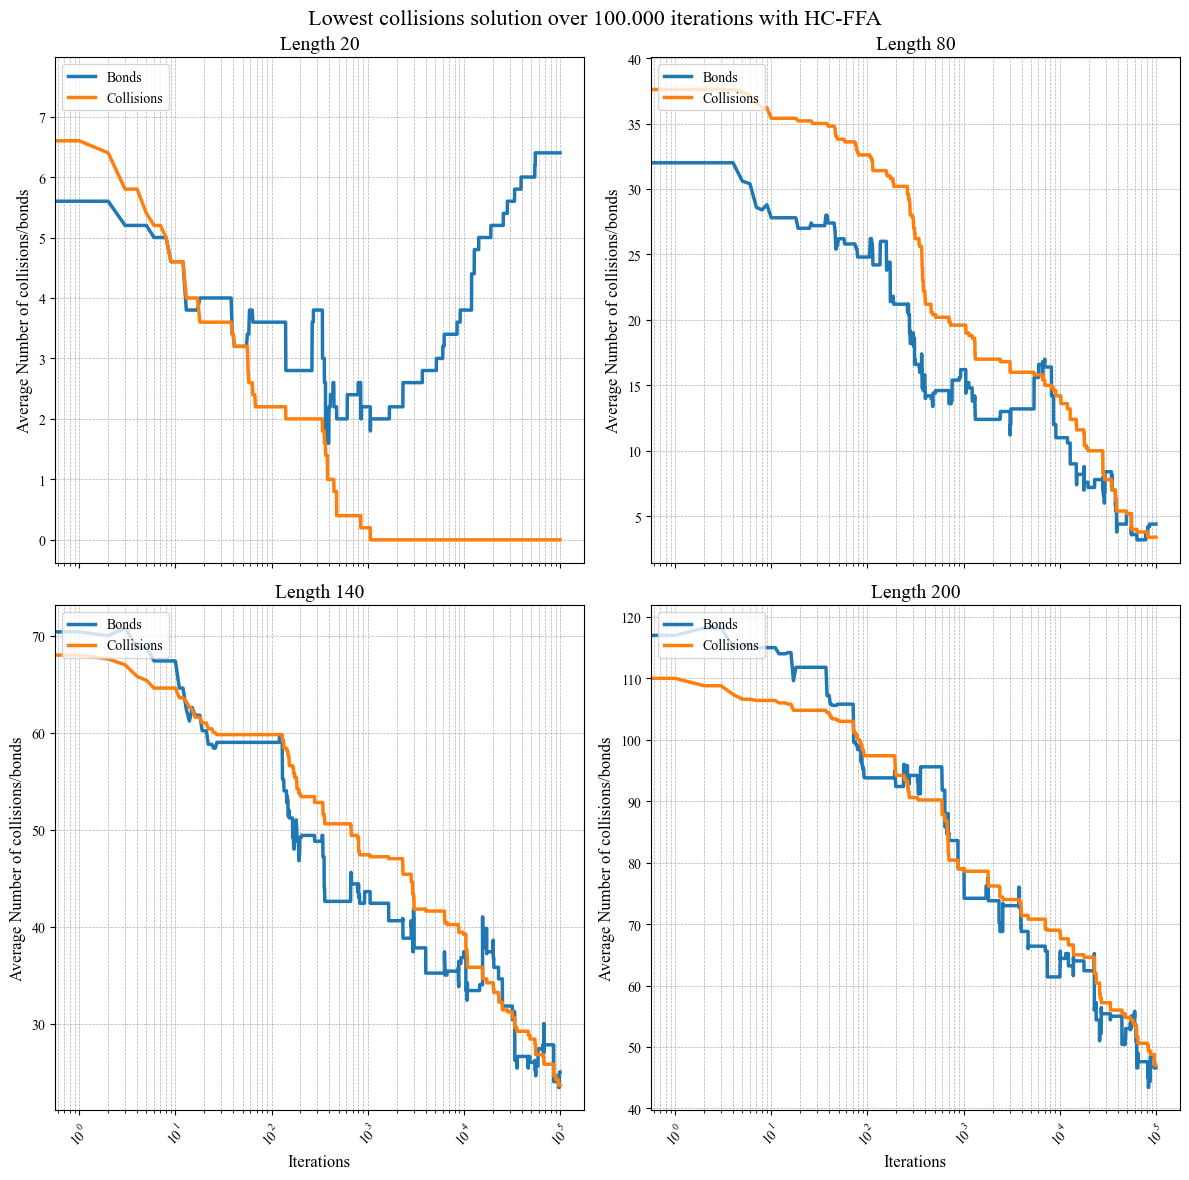

In [218]:
lengths = [20, 80, 140, 200]

# Increase figure size
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Add a figure title
fig.suptitle('Lowest collisions solution over 100.000 iterations with HC-FFA', fontsize=16)

for i, length in enumerate(lengths):
    row = i // 2
    col = i % 2
    sns.lineplot(x='Iteration', y='MinBonds', data=AvgMoHCMinFFA_Data[AvgMoHCMinFFA_Data['length'] == length], label='Bonds', linestyle="-", ax=axs[row, col], linewidth=2.5)
    sns.lineplot(x='Iteration', y='MinCol', data=AvgMoHCMinFFA_Data[AvgMoHCMinFFA_Data['length'] == length], label='Collisions', linestyle="-", ax=axs[row, col], linewidth=2.5)

    axs[row, col].set_ylabel('Average Number of collisions/bonds', fontsize=12)
    axs[row, col].legend(loc="upper left", prop={"size": 10})
    axs[row, col].set_xscale('log')
    axs[row, col].set_title(f'Length {length}', fontsize=14)
    axs[row, col].tick_params(axis='x', rotation=45)
    axs[row, col].grid(True, which="both", linestyle="--", linewidth=0.5)

    # Remove x-axis label and values for the top graphs
    if row == 0:
        axs[row, col].set_xlabel('')
        axs[row, col].set_xticklabels([])
    else:
        axs[row, col].set_xlabel('Iterations', fontsize=12)

plt.tight_layout()
plt.show()


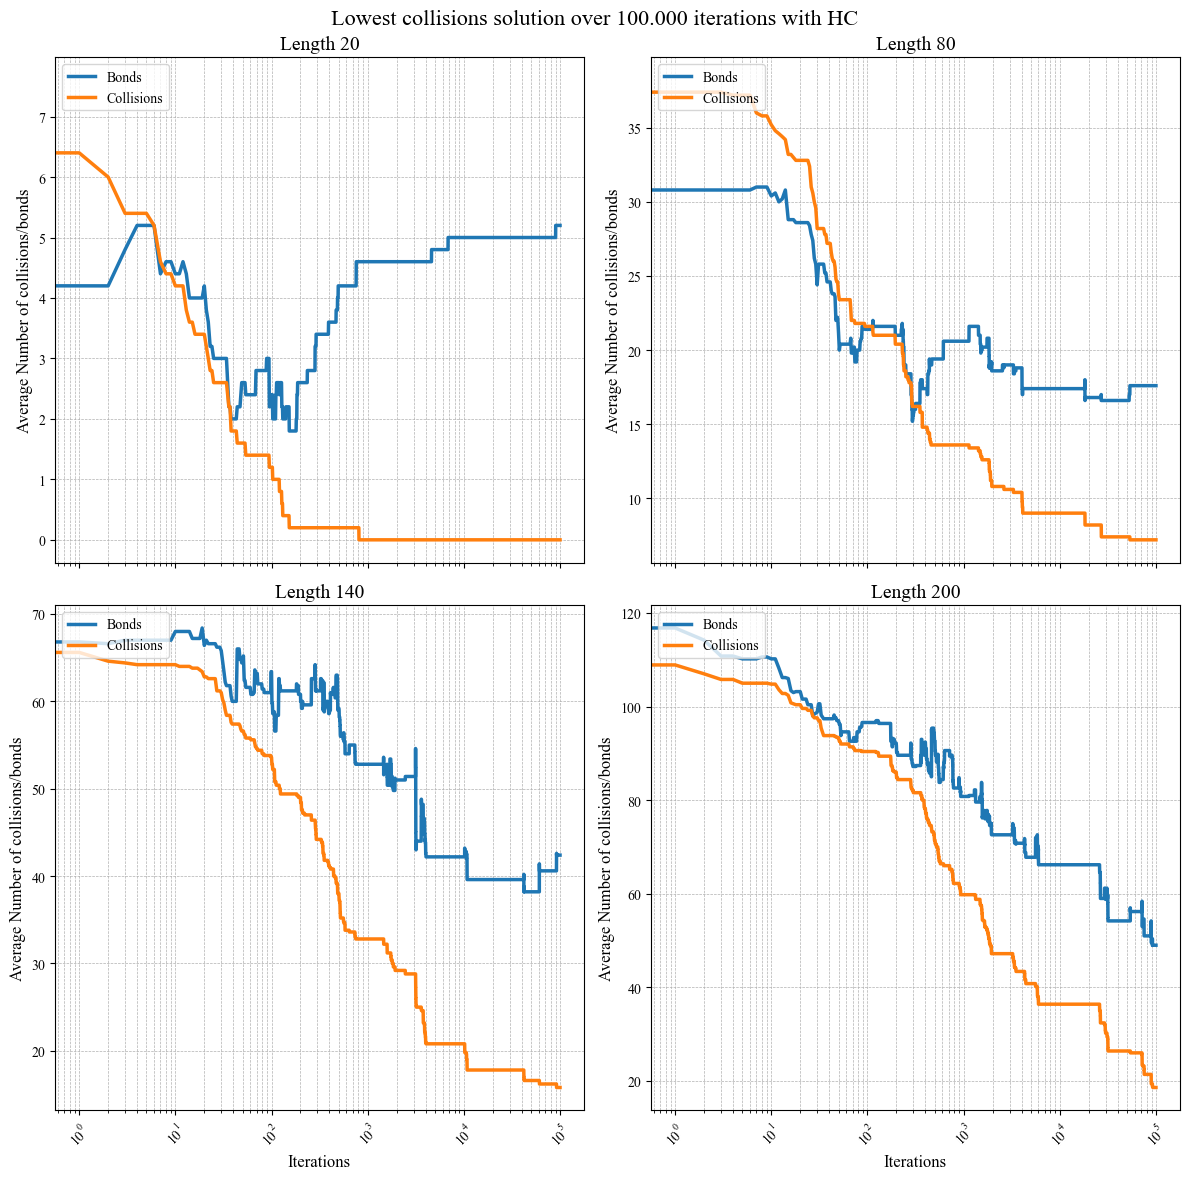

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns


lengths = [20, 80, 140, 200]

# Increase figure size
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Add a figure title
fig.suptitle('Lowest collisions solution over 100.000 iterations with HC', fontsize=16)

for i, length in enumerate(lengths):
    row = i // 2
    col = i % 2
    sns.lineplot(x='Iteration', y='MinBonds', data=AvgMoHCMin_Data[AvgMoHCMin_Data['length'] == length], label='Bonds', linestyle="-", ax=axs[row, col], linewidth=2.5)
    sns.lineplot(x='Iteration', y='MinCol', data=AvgMoHCMin_Data[AvgMoHCMin_Data['length'] == length], label='Collisions', linestyle="-", ax=axs[row, col], linewidth=2.5)

    axs[row, col].set_ylabel('Average Number of collisions/bonds', fontsize=12)
    axs[row, col].legend(loc="upper left", prop={"size": 10})
    axs[row, col].set_xscale('log')
    axs[row, col].set_title(f'Length {length}', fontsize=14)
    axs[row, col].tick_params(axis='x', rotation=45)
    axs[row, col].grid(True, which="both", linestyle="--", linewidth=0.5)

    # Remove x-axis label and values for the top graphs
    if row == 0:
        axs[row, col].set_xlabel('')
        axs[row, col].set_xticklabels([])
    else:
        axs[row, col].set_xlabel('Iterations', fontsize=12)

plt.tight_layout()
plt.show()


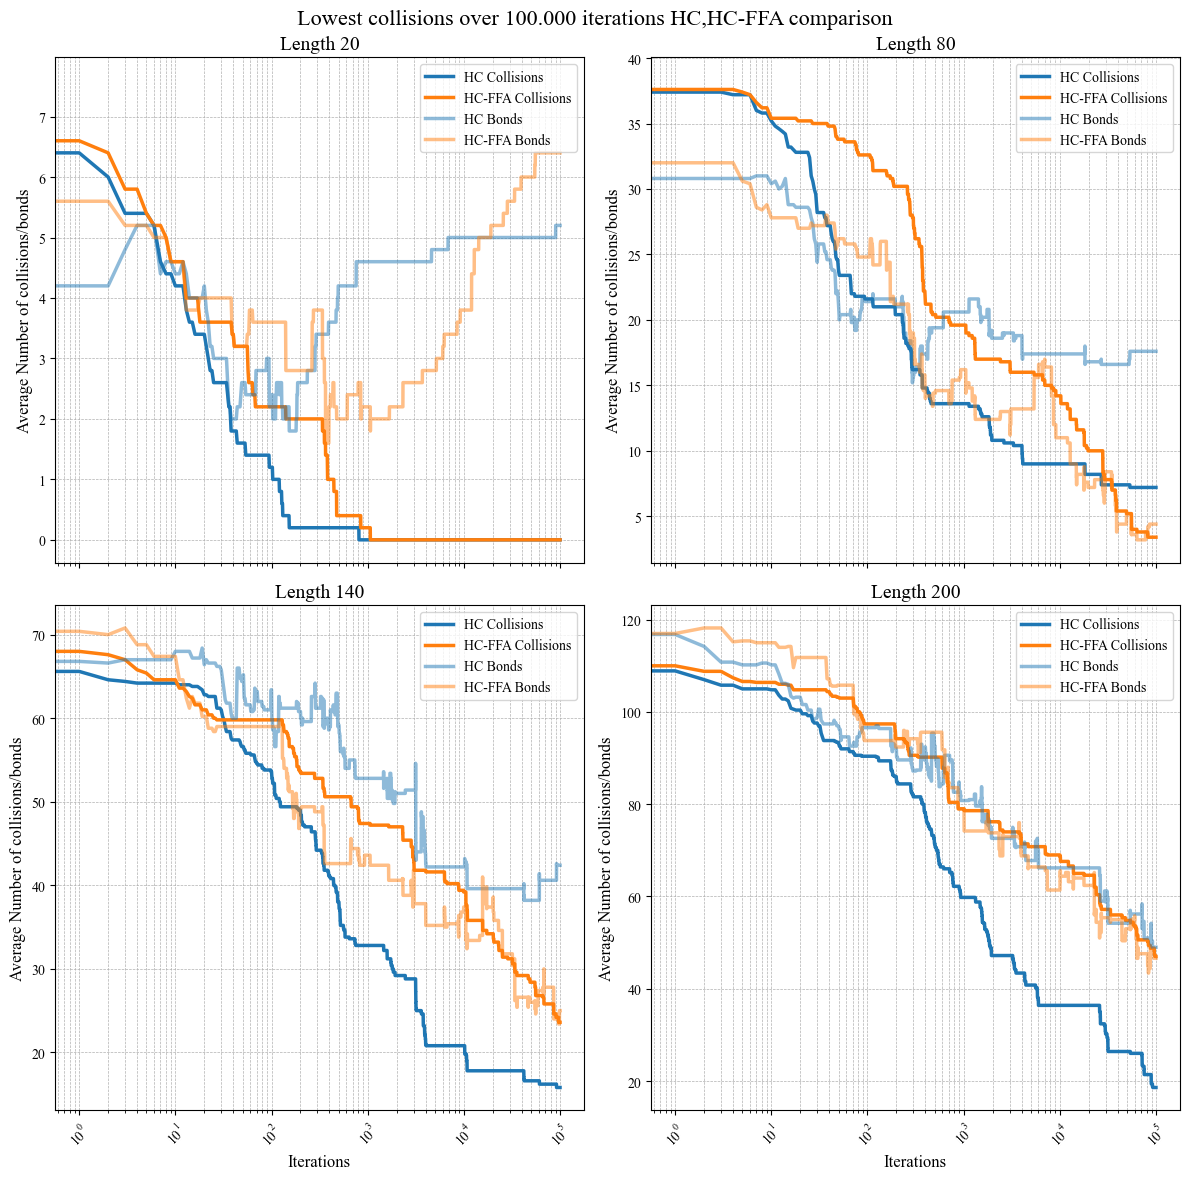

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns


lengths = [20, 80, 140, 200]

# Increase figure size
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Add a figure title
fig.suptitle('Lowest collisions over 100.000 iterations HC,HC-FFA comparison', fontsize=16)

for i, length in enumerate(lengths):
    row = i // 2
    col = i % 2
    sns.lineplot(x='Iteration', y='MinCol', data=AvgMoHCMin_Data[AvgMoHCMin_Data['length'] == length], label='HC Collisions', linestyle="-", ax=axs[row, col], linewidth=2.5)
    sns.lineplot(x='Iteration', y='MinCol', data=AvgMoHCMinFFA_Data[AvgMoHCMinFFA_Data['length'] == length], label='HC-FFA Collisions', linestyle="-", ax=axs[row, col], linewidth=2.5)
    sns.lineplot(x='Iteration', y='MinBonds', data=AvgMoHCMin_Data[AvgMoHCMin_Data['length'] == length], label='HC Bonds', linestyle="-", ax=axs[row, col], linewidth=2.5, color=sns.color_palette()[0], alpha=0.5)
    sns.lineplot(x='Iteration', y='MinBonds', data=AvgMoHCMinFFA_Data[AvgMoHCMinFFA_Data['length'] == length], label='HC-FFA Bonds', linestyle="-", ax=axs[row, col], linewidth=2.5, color=sns.color_palette()[1], alpha=0.5)
    
    axs[row, col].set_ylabel('Average Number of collisions/bonds', fontsize=12)
    axs[row, col].legend(loc="upper right", prop={"size": 10})
    axs[row, col].set_xscale('log')
    axs[row, col].set_title(f'Length {length}', fontsize=14)
    axs[row, col].tick_params(axis='x', rotation=45)
    axs[row, col].grid(True, which="both", linestyle="--", linewidth=0.5)

    # Remove x-axis label and values for the top graphs
    if row == 0:
        axs[row, col].set_xlabel('')
        axs[row, col].set_xticklabels([])
    else:
        axs[row, col].set_xlabel('Iterations', fontsize=12)

plt.tight_layout()
plt.show()


In [212]:
dataFrames = []

for i in range(len(MoHC)):
    # Access the data list for each entry
    data = MoHC["Data"][i]
    
    df = pd.DataFrame(data, columns=['Iteration', 'Fitness'])

    # Find the pair with the minimal second number using a list comprehension
    df["MaxSolution"] = df["Fitness"].apply(lambda x: max(x, key=lambda y: y[0]))
    df['MaxCol'] = [i[1] for i in df['MaxSolution']]
    df['MaxBonds'] = [i[0]  for i in df['MaxSolution']]


    df = df.drop(['MaxSolution', 'Fitness'], axis=1)

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100001))

    # Forward fill the missing fitness values
    df['MaxBonds'].ffill(inplace=True)
    df['MaxCol'].ffill(inplace=True)

    df['length'] = 20 + (20 * (( i - (i % 5)) / 5))

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
MoHCMax_Data = pd.concat(dataFrames, ignore_index=True)

In [213]:
dataFrames = []

for i in range(len(MoHCFFA)):
    # Access the data list for each entry
    data = MoHCFFA["Data"][i]
    
    df = pd.DataFrame(data, columns=['Iteration', 'Current' ,'Fitness'])

    # Find the pair with the minimal second number using a list comprehension
    df["MaxSolution"] = df["Fitness"].apply(lambda x: max(x, key=lambda y: y[0]))
    df['MaxCol'] = [i[1] for i in df['MaxSolution']]
    df['MaxBonds'] = [i[0]  for i in df['MaxSolution']]


    df = df.drop(['MaxSolution', 'Fitness', 'Current'], axis=1)

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100001))

    # Forward fill the missing fitness values
    df['MaxBonds'].ffill(inplace=True)
    df['MaxCol'].ffill(inplace=True)


    df['length'] = 20 + (20 * (( i - (i % 5)) / 5))

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
MoHCMaxFFA_Data = pd.concat(dataFrames, ignore_index=True)

In [214]:
AvgMoHCMaxFFA_Data = MoHCMaxFFA_Data.groupby(['Iteration', 'length'], as_index=False).agg({'MaxBonds':'mean', 'MaxCol':'mean'})
AvgMoHCMax_Data = MoHCMax_Data.groupby(['Iteration', 'length'], as_index=False).agg({'MaxBonds':'mean', 'MaxCol':'mean'})

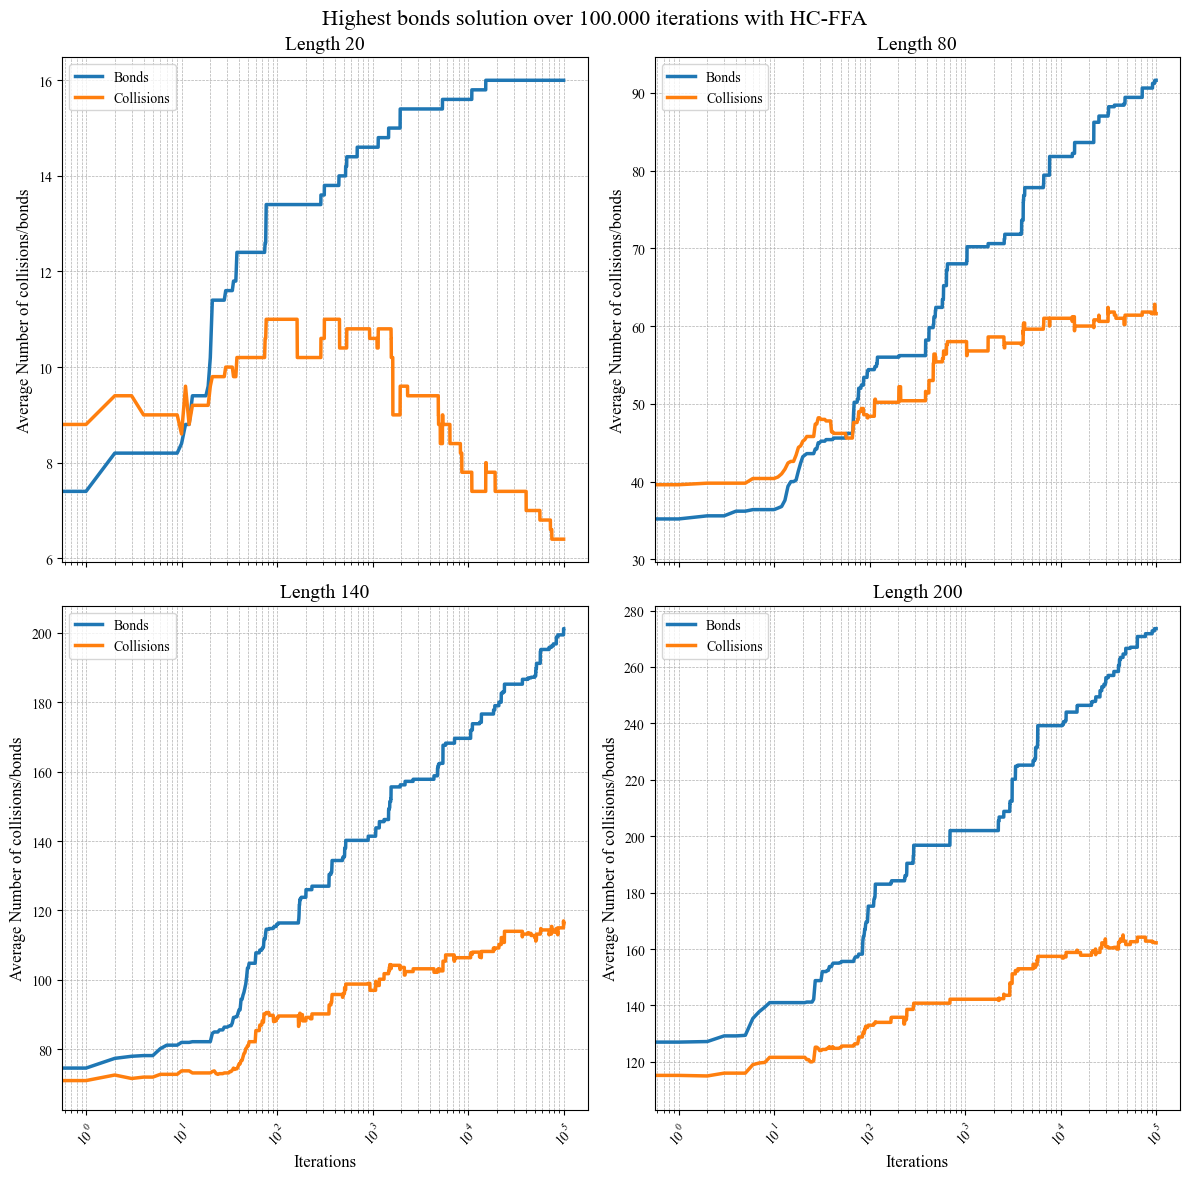

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns


lengths = [20, 80, 140, 200]

# Increase figure size
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Add a figure title
fig.suptitle('Highest bonds solution over 100.000 iterations with HC-FFA', fontsize=16)

for i, length in enumerate(lengths):
    row = i // 2
    col = i % 2
    sns.lineplot(x='Iteration', y='MaxBonds', data=AvgMoHCMaxFFA_Data[AvgMoHCMaxFFA_Data['length'] == length], label='Bonds', linestyle="-", ax=axs[row, col], linewidth=2.5)
    sns.lineplot(x='Iteration', y='MaxCol', data=AvgMoHCMaxFFA_Data[AvgMoHCMaxFFA_Data['length'] == length], label='Collisions', linestyle="-", ax=axs[row, col], linewidth=2.5)

    axs[row, col].set_ylabel('Average Number of collisions/bonds', fontsize=12)
    axs[row, col].legend(loc="upper left", prop={"size": 10})
    axs[row, col].set_xscale('log')
    axs[row, col].set_title(f'Length {length}', fontsize=14)
    axs[row, col].tick_params(axis='x', rotation=45)
    axs[row, col].grid(True, which="both", linestyle="--", linewidth=0.5)

    # Remove x-axis label and values for the top graphs
    if row == 0:
        axs[row, col].set_xlabel('')
        axs[row, col].set_xticklabels([])
    else:
        axs[row, col].set_xlabel('Iterations', fontsize=12)

plt.tight_layout()
plt.show()


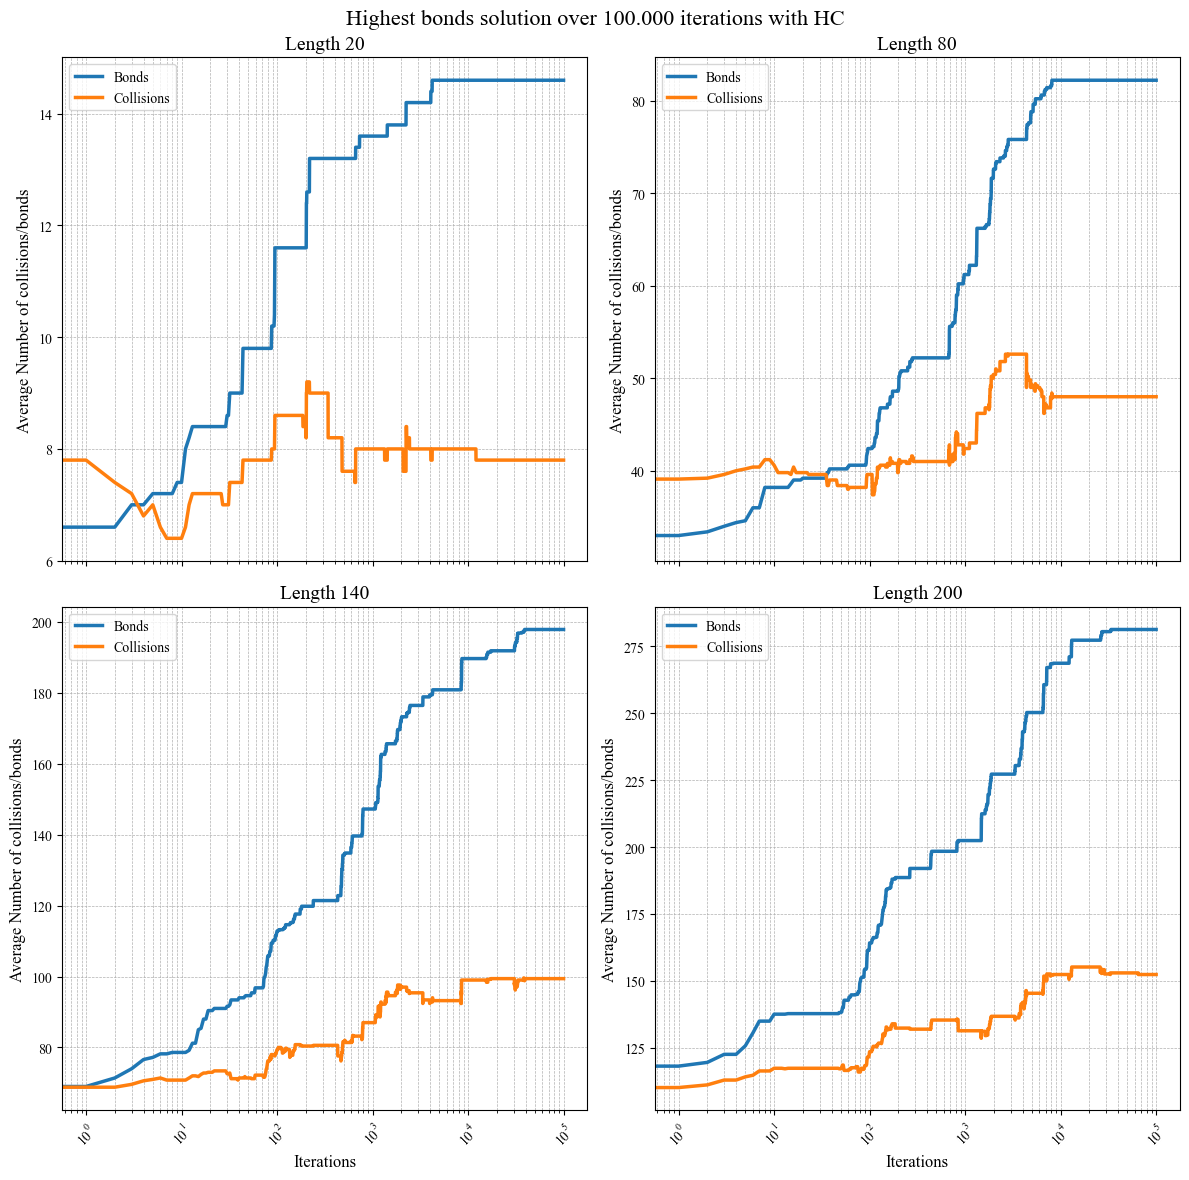

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns


lengths = [20, 80, 140, 200]

# Increase figure size
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Add a figure title
fig.suptitle('Highest bonds solution over 100.000 iterations with HC', fontsize=16)

for i, length in enumerate(lengths):
    row = i // 2
    col = i % 2
    sns.lineplot(x='Iteration', y='MaxBonds', data=AvgMoHCMax_Data[AvgMoHCMax_Data['length'] == length], label='Bonds', linestyle="-", color=sns.color_palette()[0], ax=axs[row, col], linewidth=2.5)
    sns.lineplot(x='Iteration', y='MaxCol', data=AvgMoHCMax_Data[AvgMoHCMax_Data['length'] == length], label='Collisions', linestyle="-", color=sns.color_palette()[1], ax=axs[row, col], linewidth=2.5)

    axs[row, col].set_ylabel('Average Number of collisions/bonds', fontsize=12)
    axs[row, col].legend(loc="upper left", prop={"size": 10})
    axs[row, col].set_xscale('log')
    axs[row, col].set_title(f'Length {length}', fontsize=14)
    axs[row, col].tick_params(axis='x', rotation=45)
    axs[row, col].grid(True, which="both", linestyle="--", linewidth=0.5)

    # Remove x-axis label and values for the top graphs
    if row == 0:
        axs[row, col].set_xlabel('')
        axs[row, col].set_xticklabels([])
    else:
        axs[row, col].set_xlabel('Iterations', fontsize=12)

plt.tight_layout()
plt.show()


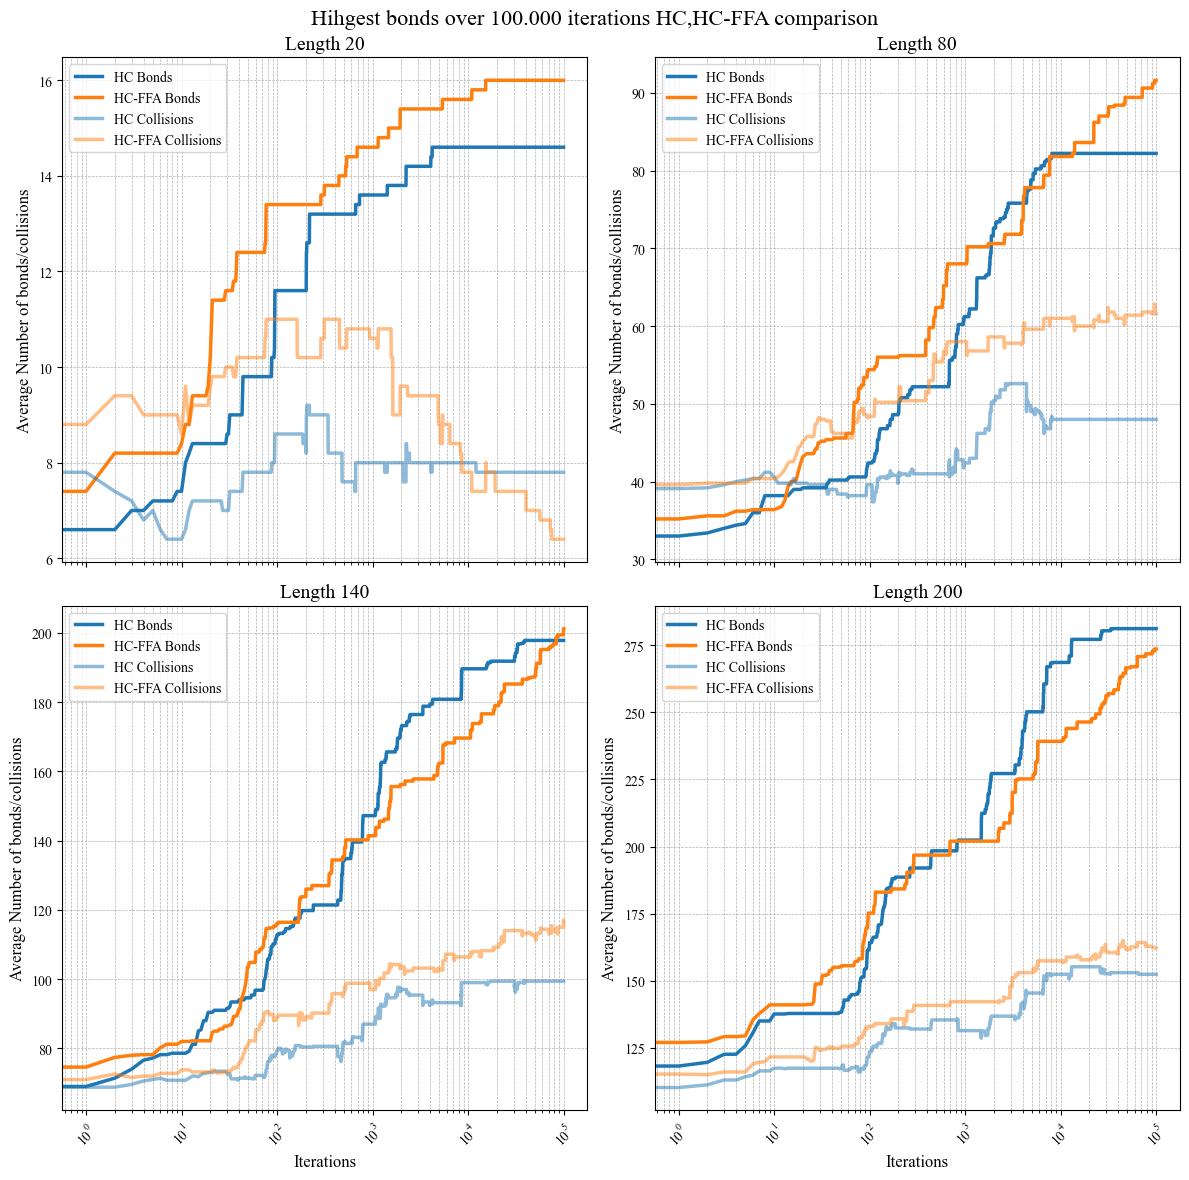

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns


lengths = [20, 80, 140, 200]

# Increase figure size
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Add a figure title
fig.suptitle('Hihgest bonds over 100.000 iterations HC,HC-FFA comparison', fontsize=16)

for i, length in enumerate(lengths):
    row = i // 2
    col = i % 2
    sns.lineplot(x='Iteration', y='MaxBonds', data=AvgMoHCMax_Data[AvgMoHCMax_Data['length'] == length], label='HC Bonds', linestyle="-", ax=axs[row, col], linewidth=2.5)
    sns.lineplot(x='Iteration', y='MaxBonds', data=AvgMoHCMaxFFA_Data[AvgMoHCMaxFFA_Data['length'] == length], label='HC-FFA Bonds', linestyle="-", ax=axs[row, col], linewidth=2.5)
    sns.lineplot(x='Iteration', y='MaxCol', data=AvgMoHCMax_Data[AvgMoHCMax_Data['length'] == length], label='HC Collisions', linestyle="-", ax=axs[row, col], linewidth=2.5, color=sns.color_palette()[0], alpha=0.5)
    sns.lineplot(x='Iteration', y='MaxCol', data=AvgMoHCMaxFFA_Data[AvgMoHCMaxFFA_Data['length'] == length], label='HC-FFA Collisions', linestyle="-", ax=axs[row, col], linewidth=2.5, color=sns.color_palette()[1], alpha=0.5)

    axs[row, col].set_ylabel('Average Number of bonds/collisions', fontsize=12)
    axs[row, col].legend(loc="upper left", prop={"size": 10})
    axs[row, col].set_xscale('log')
    axs[row, col].set_title(f'Length {length}', fontsize=14)
    axs[row, col].tick_params(axis='x', rotation=45)
    axs[row, col].grid(True, which="both", linestyle="--", linewidth=0.5)

    # Remove x-axis label and values for the top graphs
    if row == 0:
        axs[row, col].set_xlabel('')
        axs[row, col].set_xticklabels([])
    else:
        axs[row, col].set_xlabel('Iterations', fontsize=12)

plt.tight_layout()
plt.show()
